<a href="https://colab.research.google.com/github/lagom-QB/M12/blob/master/Day_02_CNN_Salary_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://www.youtube.com/watch?v=SbHx9Ps7B4g&list=RDCDWVeVZa-DA&index=27

# ---- Just some noise

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# --- Get the data

!curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  119M  100  119M    0     0  33.1M      0  0:00:03  0:00:03 --:--:-- 47.8M
Train_rev1.csv


In [4]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)

data.shape

(244768, 12)

In [5]:
data.columns

Index(['Id', 'Title', 'FullDescription', 'LocationRaw', 'LocationNormalized',
       'ContractType', 'ContractTime', 'Company', 'Category', 'SalaryRaw',
       'SalaryNormalized', 'SourceName'],
      dtype='object')

                Task: Salary Prediction

_Salary distribution is not uniform so we can't use mean squared loss_ \
    
    To solve this, 
        1. We could normalize the data to be able to use the MSE \
        2. Use a different loss

# 1. Normalize the data

(array([  398.,   237.,   361.,   558.,  1035.,  9521., 14265., 19607.,
        25126., 27534., 32996., 30095., 27265., 20446., 14604., 10847.,
         5793.,  3784.,    96.,    97.,    62.,    41.]),
 array([ 8.517393 ,  8.6850605,  8.852728 ,  9.020395 ,  9.188063 ,
         9.35573  ,  9.523398 ,  9.691066 ,  9.858733 , 10.026401 ,
        10.194068 , 10.361735 , 10.529403 , 10.69707  , 10.8647375,
        11.032405 , 11.200072 , 11.367741 , 11.535408 , 11.703075 ,
        11.870743 , 12.03841  , 12.206078 ], dtype=float32),
 <a list of 22 Patch objects>)

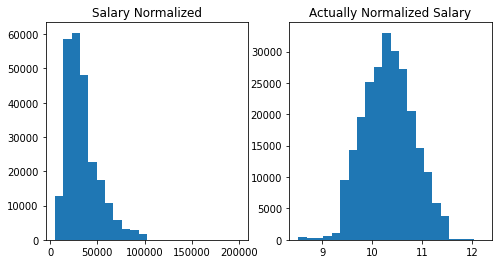

In [6]:
# Salary is our target
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8,4])

plt.subplot(1,2,1)
plt.title('Salary Normalized')
plt.hist(data['SalaryNormalized'], 
        bins = 22)

plt.subplot(1,2,2)
plt.title('Actually Normalized Salary')
plt.hist(data['Log1pSalary'],
        bins = 22)

In [7]:
text_columns = ['Title', 'FullDescription']
categorical_columns = ['ContractType', 'ContractTime', 'Company', 'Category','LocationNormalized']

target_column = 'Log1pSalary'

In [8]:
data[categorical_columns] = data[categorical_columns].fillna('NaN')
data.head(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk,10.308986
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk,10.308986


## Preprocess text

    Lowercase all text under Title and FullDescription and store in a space-separated string token

In [9]:
import nltk
from nltk.tokenize import wordpunct_tokenize

# nltk.download('punkt')

def normalize(text):
    tokens = wordpunct_tokenize(str(text).lower())
    return ' '.join(tokens)

data[text_columns] = data[text_columns].applymap(normalize) 

# nltk.tokenize.wordpunct_tokenize?

In [10]:
data['FullDescription'][2][:50]

'mathematical modeller / simulation analyst / opera'

    Build a token-to-count dictionary

In [11]:
from collections import Counter

token_to_count = Counter()

for row in data[text_columns].values.flatten():
    token_to_count.update(row.split(' '))

Text(0.5, 0, 'word_count')

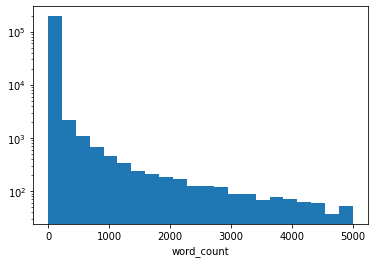

In [12]:
plt.hist(list(token_to_count.values()), 
         bins = 22, 
         log = True,
         range = [1, 5000]
        )
plt.xlabel('word_count')

In [13]:
tokens = [token for token, count in token_to_count.items() if count > 10]

# sorted(tokens)

In [14]:
# special token for unknow and empty words

UNK, PAD = 'UNK', 'PAD'

tokens = [UNK, PAD] + sorted(tokens)

    Build token-to-index dictionary

In [15]:
token_to_index = {word:idx for idx,word in enumerate(tokens)}

    Convert vocabulary to matrices

In [16]:
UNK_IDX, PAD_IDX = map(token_to_index.get, [UNK, PAD])

In [17]:
def to_matrix(sequence, max_len = None):
    if isinstance(sequence[0], str):
        sequence = list(map(str.split, sequence))
        
    max_len = min(max(map(len, sequence)), max_len or float('inf'))
    
    matrix = np.full((len(sequence), max_len), np.int32(PAD_IDX))
    
    for i, seq in enumerate(sequence):
        row_idx = [token_to_index.get(word, UNK_IDX) for word in seq[:max_len]]
        matrix[i,:len(row_idx)] = row_idx
        
    return matrix

    Encode categorical data
    
    Options:
        1.One-hot
        2.BOW
        3.TFIDF

In [18]:
from sklearn.feature_extraction import DictVectorizer

top_companies, top_counts = zip(*Counter(data['Company']).most_common(500))
recognized_companies = set(top_companies)
data['Company'] = data['Company'].apply(lambda company: company if company in recognized_companies else 'Other')

categorical_vectorizer = DictVectorizer(dtype = np.float32, sparse = False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis = 1))

# DictVectorizer?

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

In [19]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(data, test_size = .3 ,random_state = 22)

train.index = range(len(train))
validation.index = range(len(validation))

In [20]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    
    batch = {}
    batch["Title"]           = to_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = to_matrix(data["FullDescription"].values, max_len)
    batch['Categorical']     = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IDX, pad_ix=PAD_IDX,):
    
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    
    dropout_mask &= matrix != pad_ix
    
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [21]:
batch_1 = make_batch(train[:3], max_len=22)

    Notice that the main model here has 3 parts: 
        1.Title encoder
        2.Description encoder
        3.Categorical features encoder.
    
    We'll fit all these into a network to predict the salary

In [22]:
# Imports 

import torch
from torch import nn
import torch.nn.functional as F

In [23]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((0, 2, 1))

In [24]:
#  To generate mini-batches,

def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

In [25]:
iterator = iterate_minibatches(train, 3)
batch, target = next(iterator)

In [26]:
n_tokens=len(tokens)
n_cat_features=len(categorical_vectorizer.vocabulary_)
hid_size=64
n_max = 2
simple_model = nn.Sequential()

simple_model.add_module('emb', nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size))
simple_model.add_module('reorder', Reorder())

simple_model.add_module('conv1', nn.Conv1d(hid_size, hid_size*2, kernel_size = 2))
simple_model.add_module('relu' , nn.ReLU(True))

simple_model.add_module('conv2', nn.Conv1d(hid_size*2, hid_size*2, kernel_size = 3))
simple_model.add_module('relu2' , nn.ReLU(True))

simple_model.add_module('conv3', nn.Conv1d(hid_size*2, hid_size*2, kernel_size = 3))
simple_model.add_module('bn1' , nn.BatchNorm1d(hid_size*2))
simple_model.add_module('adaptive_pool', nn.AdaptiveAvgPool1d(n_max))
simple_model.add_module('flatten', nn.Flatten())
simple_model.add_module('out', nn.Linear(hid_size*2*n_max, 1))

__It's a regression problem__

Our prediction is a single number _Salary_

In [27]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model = simple_model.to(device)

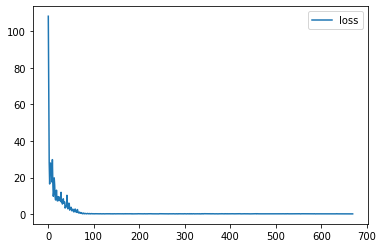

In [28]:
from IPython.display import clear_output
from random import sample

epochs = 1

opt = torch.optim.SGD(model.parameters(), lr = .002, momentum = .9)
loss_func = nn.MSELoss()         

history = []
for epoch_num in range(epochs):
    for idx, (batch, target) in enumerate(iterate_minibatches(train)):
        # Preprocessing the batch data and target
        batch = torch.tensor(batch['FullDescription'], dtype=torch.long).to(device)
        target = torch.tensor(target).to(device)


        predictions = model(batch)
        predictions = predictions.view(predictions.size(0))

        loss = loss_func(predictions, target)        

        loss.backward()
        opt.step()
        opt.zero_grad()

        history.append(loss.item())
        if (idx+1)%10==0:
            clear_output(True)
            plt.plot(history,label='loss')
            plt.legend()
            plt.show()

        To evaluate the model, do model.eval()

In [29]:
%timeit
from tqdm import tqdm, tqdm_notebook
 
model.eval()
    
def print_metrics(model, data, batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch = torch.tensor(batch_x['FullDescription'], dtype=torch.long).to(device)
        batch_pred = simple_model(batch)[:, 0].detach().cpu().numpy()
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error
   
print_metrics(model, train, name='Train', batch_size = 222)
print_metrics(model, validation, name='Val', batch_size = 222)

Train results:
Mean square error: 0.24139
Mean absolute error: 0.39412
Val results:
Mean square error: 0.24240
Mean absolute error: 0.39452


(17799.942710876465, 28970.24647140503)

Implement the three headed network (title|FullDescription|categorical)

In [30]:
class ThreeInputsNetwork(nn.Module):
    def __init__(self,
                 n_tokens = len(tokens),
                 n_categorical_features = len(categorical_vectorizer.vocabulary_),
                 hid_size = 64):
        super(TwoInputsNet, self).__init__()
        self.title_emb = nn.Embedding(n_tokens, 
                                      embedding_dim= hid_size)
        self.full_emb = nn.Embedding(num_embeddings=n_tokens,
                                     embedding_dim = hid_size)
        self.category_out = nn.Embedding(num_embeddings=n_categorical_features,
                                         embedding_dim = hid_size)
        
    def forward(self,
                whole_input):
        input1, input2, input3 = whole_input
        title_beg = self.title_emb(input1).permute((0,2,1))
        title = self.title_emb(input1).permute((0,2,1))

        full_beg = self.full_emb(input2).permute((0, 2, 1))
        full = self.full_emb(input2).permute((0, 2, 1))

        category = self.category_out(input3).permute((0, 2, 1))

        concatenated = torch.cat([title.view(title.size(0), -1),
                                  full.view(full.size(0), -1),
                                  category.view(category.size(0), -1)],
                                 dim = 1)
        
        out = concatenated

        return out